In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv('Output_Data/Rolling_Predicted_SP_lg_pr.csv')

In [3]:
# Assuming 'df' is your DataFrame
cols = df.columns.tolist()
cols.insert(-2, cols.pop(cols.index('SP_lg_pr')))
df = df[cols]

# rename SP_lg_pr to SP_lg_pr(Time_T), Next_Week_SP_lg_pr to SP_lg_pr(Time_T+1), Predicted_Next_Week_SP_lg_pr to Predicetd_SP_lg_pr(Time_T+1)
df.rename(columns={'SP_lg_pr': 'SP_lg_pr(Time_T)', 'Next_Week_SP_lg_pr': 'SP_lg_pr(Time_T+1)', 'Predicted_Next_Week_SP_lg_pr': 'Predicted_SP_lg_pr(Time_T+1)'}, inplace=True)

In [4]:
Backtest = df.copy()
# set the index to the date
Backtest.set_index('Date', inplace=True)
# keep the last three columns
Backtest = Backtest.iloc[:, -3:]

# Calculate the percentage change for the trading signal
Backtest['Perc_Change'] = ((Backtest['Predicted_SP_lg_pr(Time_T+1)'] - Backtest['SP_lg_pr(Time_T)']) / Backtest['SP_lg_pr(Time_T)']) * 100

Backtest['Predicted_Return_Sign'] = np.where(Backtest['Perc_Change'] > 0.05, 1, np.where(Backtest['Perc_Change'] < -0.05, -1, 0))


# remove the Perc_Change column
# Backtest.drop(columns='Perc_Change', inplace=True)

Backtest.head(30)   

,SP_lg_pr(Time_T),SP_lg_pr(Time_T+1),Predicted_SP_lg_pr(Time_T+1),Perc_Change,Predicted_Return_Sign
Date,,,,,
2021-05-12,8.309687,8.322559,8.309902,0.002586,0
2021-05-19,8.322559,8.341885,8.321608,-0.011433,0
2021-05-26,8.341885,8.344771,8.341365,-0.006226,0
2021-06-02,8.344771,8.347484,8.351182,0.076823,1
2021-06-09,8.347484,8.348467,8.348923,0.017242,0
2021-06-16,8.348467,8.352752,8.349528,0.012709,0
2021-06-23,8.352752,8.365789,8.352616,-0.001637,0
2021-06-30,8.365789,8.379798,8.366671,0.010544,0
2021-07-07,8.379798,8.383502,8.381940,0.025563,0


In [5]:
# read the SP500 price data
SP500 = pd.read_csv("Input_Data/^SPX.csv")
SP500.set_index('Date', inplace=True)

start_date = Backtest.index[0]
end_date = Backtest.index[-1]
print(start_date, end_date)

# select SP500 price data between start_date and end_date
SP500 = SP500.loc[start_date:end_date]

2021-05-12 2024-01-31


In [6]:
# merge SP500 price data to Backtest
Combined = Backtest.merge(SP500, how='right', left_index=True, right_index=True)
# drop columns of High, Low, Close, and Volume
Final = Combined.drop(['High', 'Low', 'Adj Close', 'Volume'], axis=1)

# forward fill the missing values for Predicted_Return_Sign	
Final['Predicted_Return_Sign'] = Final['Predicted_Return_Sign'].fillna(method='ffill')
Final['Open'] = Final['Open'].shift(-1)
# drop rows which its Open Column is NaN
Final.dropna(subset=['Open'], inplace=True)

### Backtest

In [7]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [8]:
# initialize parameters
initial_balance = 10000000  # initial balance
# margin_ratio = 0.1  # margin ratio
commission_rate = 0.001  # transaction fee
# contract_multiplier = 100  # contract multiplier of futures
# balance_usage_ratio = 0.1  # balance usage ratio

# balance_usage_ratio / margin_ratio = leverage_ratio

trade_times = 0
right_times = 0
accumulated_earnings = 0
accumulated_losses = 0

# initialize account information
current_balance = initial_balance
# frozen_balance = 0
open_positions = {'Direction':'No_Position'}  # current position records
order_records = []  # order records 
account_values = []  # account values record

In [9]:
# Update the signal calculation function to consider future signals
def calculate_signal(data):
    data_copy = data.copy()  
    if data_copy['Predicted_Return_Sign'].iloc[-1] == 1.0:
        return "Long"
    elif data_copy['Predicted_Return_Sign'].iloc[-1] == -1.0:
        if 1.0 in data_copy['Predicted_Return_Sign'].values:
            return "Short"  # If there is a later 1.0, consider the current -1.0 as "Short"
        else:
            return "No_Signal_Update"  # If there are no later 1.0, keep it as "No_Signal_Update"
    else:
        return "No_Signal_Update"

In [10]:
def open_position(window_data, signal):
    global current_balance, open_positions, order_records, trade_times, right_times, accumulated_earnings, accumulated_losses

    latest_price = window_data['Open'].iloc[-1]
    position_size = math.floor(current_balance / latest_price)


    open_positions = {
        'Symbol': 'SP500',
        'PositionSize':position_size,
        'AveragePrice':latest_price, 
        'Direction':signal
    }

    order_records.append({
        'DateTime':window_data.index[-1], 
        'Action':'Open_Position', 
        'Symbol': 'SP500',
        'Price':latest_price, 
        'Direction':signal
    })

In [11]:
def close_position(window_data):
    global current_balance, open_positions, order_records, trade_times, right_times, accumulated_earnings, accumulated_losses

    latest_price = window_data['Open'].iloc[-1]

    if open_positions['Direction'] == "Long":
        profit_loss = (window_data['Open'].iloc[-1] - open_positions['AveragePrice']) * open_positions['PositionSize']
        profit_loss -= commission_rate * open_positions['PositionSize'] * window_data['Open'].iloc[-1]
    elif open_positions['Direction'] == "Short":
        profit_loss = (open_positions['AveragePrice'] - window_data['Open'].iloc[-1]) * open_positions['PositionSize']
        profit_loss -= commission_rate * open_positions['PositionSize'] * window_data['Open'].iloc[-1]
    else:
        profit_loss = 0

    current_balance += profit_loss

    open_positions = {
        'Symbol': 'SP500',
        'PositionSize': 0,
        'AveragePrice':  0,
        'Direction': 'No_Position'
    }

    order_records.append({
        'DateTime':window_data.index[-1], 
        'Action':'Close_Position', 
        'Symbol': 'SP500',
        'Price':latest_price, 
        'Quantity':open_positions['PositionSize'],
        'ProfitLoss':profit_loss,
        'Direction':open_positions['Direction']
    })


    if profit_loss > 0:
        right_times += 1
        accumulated_earnings += profit_loss
    else:
        accumulated_losses += profit_loss
    
    trade_times += 1

In [12]:
# Modify the plot_account_values function to correctly assign colors for Long and Short positions
def plot_account_values(df):

    datetime = df.index  # Use the DataFrame's index directly

    net_balance = df['NetBalance'].pct_change().fillna(0).add(1).cumprod().subtract(1)
    net_price = df['NetPrice'].pct_change().fillna(0).add(1).cumprod().subtract(1)

    # net_balance = np.array(df['NetBalance'])
    # net_price = np.array(df['NetPrice'])
    direction = np.array(df['Direction'])

    fig, ax = plt.subplots()

    # plot NetBalance and NetPrice curves
    ax.plot(datetime, net_balance, label='Strategy Return (SR))', color='black', linewidth=0.7 )
    ax.plot(datetime, net_price, label='SP Return (SP)', color='blue', linewidth=0.7)

    # Adjust annotations and other datetime-related operations to use 'datetime' directly
    # For example:
    plt.annotate(f'Current SR {net_balance[-1]:.2f}', 
             (datetime[-1], net_balance[-1]), 
             xytext=(-10, -10), textcoords='offset points', 
             ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    plt.annotate(f'Current SP: {net_price[-1]:.2f}', 
             (datetime[-1], net_price[-1]), 
             xytext=(-10, -10), textcoords='offset points', 
             ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    # fill the area between NetBalance and NetPrice curves with appropriate colors for Long and Short positions
    # for i in range(len(datetime)):
    #     if direction[i] == "Long":
    #         rect = mpatches.Rectangle((datetime[i], ax.get_ylim()[0]),
    #                                   width=pd.Timedelta(minutes=1), height=ax.get_ylim()[1],
    #                                   color='green', alpha=0.03)  # Change color to green for Long position
    #         ax.add_patch(rect)
    #     elif direction[i] == "Short":
    #         rect = mpatches.Rectangle((datetime[i], ax.get_ylim()[0]),
    #                                   width=pd.Timedelta(minutes=1), height=ax.get_ylim()[1],
    #                                   color='red', alpha=0.03)  # Change color to red for Short position
    #         ax.add_patch(rect)

    for i in range(len(datetime)):
        if direction[i] == "Long":
            rect = mpatches.Rectangle((datetime[i], ax.get_ylim()[0]),
                                    width=pd.Timedelta(days=7), 
                                    height=ax.get_ylim()[1] - ax.get_ylim()[0],  # Adjusted height
                                    color='green', alpha=0.03)  # Change color to green for Long position
            ax.add_patch(rect)
        elif direction[i] == "Short":
            rect = mpatches.Rectangle((datetime[i], ax.get_ylim()[0]),
                                    width=pd.Timedelta(days=7), 
                                    height=ax.get_ylim()[1] - ax.get_ylim()[0],  # Adjusted height
                                    color='red', alpha=0.03)  # Change color to red for Short position
            ax.add_patch(rect)


    ax.xaxis_date()
    fig.autofmt_xdate()
    ax.set_title('Strategy Return and SP Return Over Time\nred:Short position  green:Long position  Other:No position')  # Update legend for color changes
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.legend(loc='upper left')

In [13]:
def strategy_evaluation(df, trade_times, right_times):
    # Ensure 'df.index' is of datetime type. This is crucial for plotting and calculations that involve dates.
    # If 'df.index' is not a datetime index, you should convert it before this function or within this function using:
    # df.index = pd.to_datetime(df.index)

    datetime = df.index  # This assumes 'df.index' is already a datetime type.

    evaluation_table = pd.DataFrame()

    # Calculate strategy return
    trading_strategy_return = df['StrategyReturn'].iloc[-1]
    gold_return = df['SP500_Return'].iloc[-1]
    evaluation_table.loc['Strategy Return', 'Value'] = round(trading_strategy_return, 3)

    # Calculate annualized return
    net_value = df['NetBalance'].iloc[-1] / df['NetBalance'].iloc[0]
    gold_net_value = df['NetPrice'].iloc[-1] / df['NetPrice'].iloc[0]
    annual_return = net_value ** (252 / len(df)) - 1
    gold_annual_return = gold_net_value ** (252 / len(df)) - 1
    evaluation_table.loc['Strategy Annualized Return', 'Value'] = round(annual_return, 3)

    evaluation_table.loc['SP500 Return', 'Value'] = round(gold_return, 3)
    evaluation_table.loc['SP500 Annualized Return', 'Value'] = round(gold_annual_return, 3)

    # Calculate excess return
    excess_return = df['NetBalance'].iloc[-1] - df['NetPrice'].iloc[-1]
    evaluation_table.loc['Excess Return', 'Value'] = round(excess_return, 3)

    daily_returns = df['NetBalance'].pct_change()
    volatility = daily_returns.std() * np.sqrt(252)
    evaluation_table.loc['Volatility', 'Value'] = round(volatility, 3)

    risk_free_rate = 0.03
    sharpe_ratio = (annual_return - risk_free_rate) / volatility
    evaluation_table.loc['Sharpe Ratio', 'Value'] = round(sharpe_ratio, 3)

    df['max_Drawdown'] = df['NetBalance'] / df['NetBalance'].cummax() - 1
    drawdown = df['max_Drawdown'].min()
    evaluation_table.loc['Max Drawdown', 'Value'] = round(drawdown, 3)

    evaluation_table.loc['Trade Times', 'Value'] = trade_times
    win_rate = round(right_times / trade_times, 3) if trade_times > 0 else 0
    evaluation_table.loc['Win Rate', 'Value'] = win_rate

    if right_times == 0:
        profit_loss_ratio = 0
    elif (trade_times - right_times) == 0:
        profit_loss_ratio = (accumulated_earnings / right_times)
    else:
        profit_loss_ratio = (accumulated_earnings / right_times) / (-accumulated_losses / (trade_times - right_times))
    evaluation_table.loc['Profit/Loss Ratio', 'Value'] = round(abs(profit_loss_ratio), 3)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(datetime, df['StrategyReturn'], label='Strategy Return')
    plt.title('Strategy Return Curve')
    plt.annotate(f'Current StrategyReturn: {trading_strategy_return:.2f}', 
                 (datetime[-1], df['StrategyReturn'].iloc[-1]), 
                 xytext=(-10, -10), textcoords='offset points', 
                 ha='right', va='top', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(datetime, df['max_Drawdown'], label='Max Drawdown')
    plt.title('Max Drawdown Curve')
    plt.annotate(f'Max Drawdown: {drawdown:.2f}', 
                 (datetime[-1], df['max_Drawdown'].iloc[-1]), 
                 xytext=(-10, -10), textcoords='offset points', 
                 ha='right', va='top', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.axis('off')  
    plt.table(cellText=evaluation_table.reset_index().values,
              colLabels=['Metric', 'Value'],
              cellLoc='center',
              loc='center')
    plt.title('Strategy Evaluation Table')

    
    return evaluation_table, df
   

In [14]:
for i in range(len(Final)):
    window_data = Final.iloc[:i+1]
    signal = calculate_signal(window_data)
    
    # if signal == "Long" and open_positions['Direction'] == "No_Position":
    #     open_position(window_data, signal)
    # elif signal == "Short" and open_positions['Direction'] == "Long":
    #     # Close the long position if a short signal is received, instead of opening a short position
    #     close_position(window_data)
    # # Removed the condition to open a short position
    # else:
    #     pass

# ################ Long Short Strategy
    if (signal == "Long" or signal == "Short") and open_positions['Direction'] == "No_Position":
        open_position(window_data, signal)

    elif signal == "Long" and open_positions['Direction'] == "Short":
        close_position(window_data)  # close old position first 
        open_position(window_data, signal)  # then open new position 

    elif signal == "Short" and open_positions['Direction'] == "Long":
        close_position(window_data)  # close old position first 
        open_position(window_data, signal)  # then open new position 

    else:
        pass
    
# ################



    latest_price = window_data['Open'].iloc[-1]

    if open_positions['Direction'] == "Long":
        profit_loss = (latest_price - open_positions['AveragePrice']) * open_positions['PositionSize']
    elif open_positions['Direction'] == "Short":
        profit_loss = (open_positions['AveragePrice'] - latest_price) * open_positions['PositionSize']
    else:
        profit_loss = 0
    
    total_balance = current_balance + profit_loss

    account_values.append({
        'DateTime':window_data.index[-1],
        'TotalBalance':total_balance,
        'CurrentBalance':current_balance,
        'ProfitLoss':profit_loss,
        'LatestPrice':latest_price,
        'Direction':open_positions['Direction'],
        'NetBalance':round(total_balance/initial_balance,2),
        'NetPrice':round(latest_price/window_data['Open'].iloc[0],2),
        'StrategyReturn':round(total_balance/initial_balance-1,2),
        'SP500_Return':round(latest_price/window_data['Open'].iloc[0]-1,2)
    })


    if current_balance + profit_loss < 0:
        close_position(window_data)

In [15]:
df_account_values = pd.DataFrame(account_values)
df_account_values.set_index('DateTime', inplace=True)
df_account_values.to_csv("Output_Data/Long_Short_Account_Values.csv")

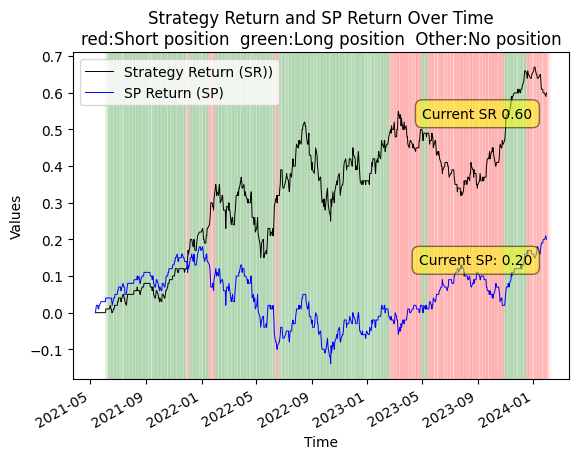

In [16]:
# Convert the index to datetime if it's not already in datetime format
df_account_values.index = pd.to_datetime(df_account_values.index)

# Then, call the plot_account_values function
plot_account_values(df_account_values)

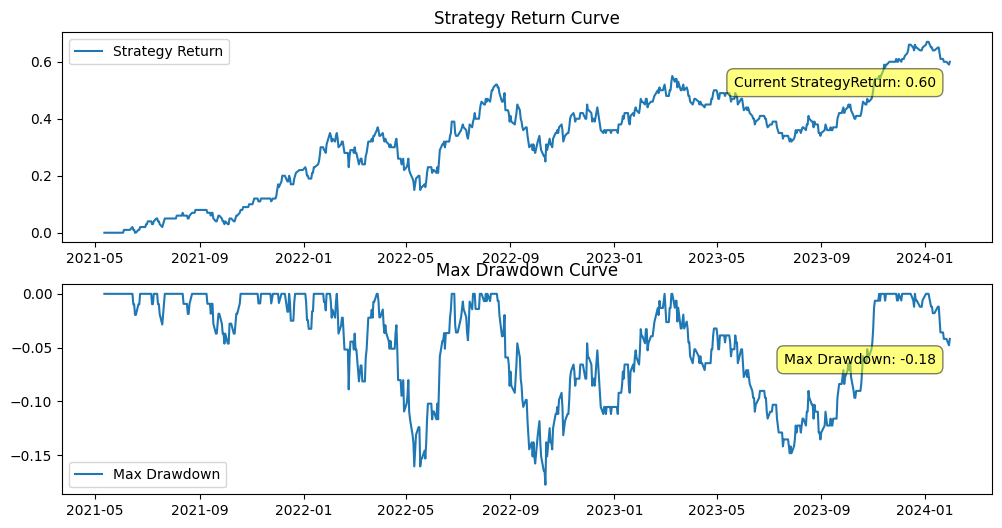

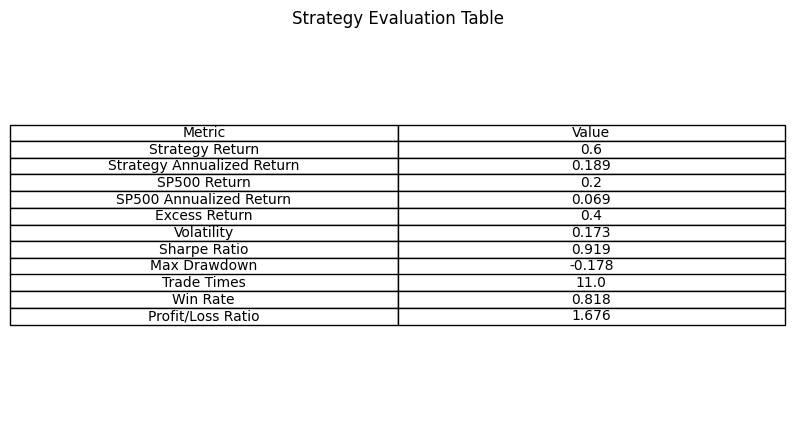

In [17]:
# Assuming df_account_values is correctly structured and includes a 'DateTime' index
_, df_strat_evalue = strategy_evaluation(df_account_values, trade_times, right_times)

# Convert index to 'DateTime' if it's not already a column
df_strat_evalue['DateTime'] = df_strat_evalue.index if 'DateTime' not in df_strat_evalue.columns else df_strat_evalue['DateTime']

# Ensure 'max_Drawdown' exists in df_strat_evalue
if 'max_Drawdown' not in df_strat_evalue.columns:
    # You need to calculate or ensure max_Drawdown is correctly populated in df_strat_evalue
    pass  # Placeholder for actual calculation or correction

# Now, proceed with your original intention
df_strat_evalue['Year'] = df_strat_evalue['DateTime'].dt.year
df_strat_evalue['MaxDrawdown'] = df_strat_evalue.groupby('Year')['max_Drawdown'].transform('min')